# Configuración de cuenta y montaje de Google Storage

En primer lugar nos autenticamos con nuestra cuenta ucm.es

In [1]:
from google.colab import auth
auth.authenticate_user()

Ahora instalamos gcsfuse

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  20508      0 --:--:-- --:--:-- --:--:-- 20508
OK
33 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 13.3 MB of archives.
After this operation, 30.7 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 129501 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.12_amd64.deb ...
Unpacking gcsfuse (0.41.12) ...
Setting up gcsfuse (0.41.12) ...


Creamos un directorio donde vamos a montar el bucket de Google Storage:

In [4]:
!mkdir gcs
!gcsfuse --implicit-dirs cabahla gcs

mkdir: cannot create directory ‘gcs’: File exists
2023/02/08 17:24:46.347122 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/gcs
2023/02/08 17:24:46.405510 Opening GCS connection...
2023/02/08 17:24:47.527748 Mounting file system "cabahla"...
2023/02/08 17:24:47.528679 File system has been successfully mounted.


# Ejemplo de ajuste de parámetros en una ecuación diferencial de primer orden

En primer lugar, importamos las bibliotecas necesarias:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from scipy.optimize import curve_fit
from scipy.integrate import odeint

Ahora definimos el modelo ODE que representa el sistema exacto:

$$
\frac{dr}{dt} = -k_r \cdot r(t) + k_p \cdot p(t) + k_b \cdot b(t)
$$

, con $k_r=1.3$, $k_p=0.9$ y $k_b=0.8$, $r(t)$ es la salida del sistema (o estado) y $p(t)$ y $b(t)$ con las entradas del mismo (normalmente llamadas **u**).

En realidad lo que tendríamos en un archivo CSV con unas medidas reales.

In [ ]:
def emms_solver(t_array, T, r0, p, b):
    kr = 1.3  # kr constant
    kp = 0.9  # kp constant
    kb = 0.8  # kb constant

    def emms_model(r, t):
        k = int(t/T)
        drdt = -kr*r + kp*p[k] + kb*b[k]
        return drdt

    sol_emms = odeint(emms_model, r0, t_array)
    return sol_emms[:, 0]

Ahora nos definimos el domino, para calcular el valor de la variable **teórica** en dicho dominio:

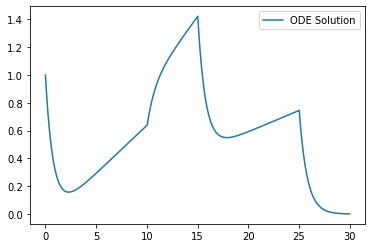

In [ ]:
t_array, T = np.linspace(0, 30, 1000, retstep=True)
p = [t/10 if t < 15 else 0 for t in t_array]
b = [t/20 if t > 10 and t < 25 else 0 for t in t_array]
r0 = 1  # Initial condition of the model
r = emms_solver(t_array, T, r0, p, b)
# print(t_array)
# plt.figure(1)
plt.plot(t_array, r, label='ODE Solution')
plt.legend()
plt.show()

Ahora nos definimos el resolutor. Ojo al parámetro `t_generic`, que puede ser tanto un escalar como el array de tiempo.

In [ ]:
def my_solver(t_generic, T, kr, kp, kb, r0, p, b):
    curr_kr = kr
    curr_kp = kp
    curr_kb = kb
    curr_r0 = r0
    def my_model(r, t):
        k = int(t/T)
        if k >= len(t_array):
            k = len(t_array)-1
        drdt = -curr_kr*r + curr_kp*p[k] + curr_kb*b[k]
        return drdt

    sol_r = odeint(my_model, curr_r0, t_generic)
    return sol_r[:, 0]

def fit_function(t, kr, kp, kb):
    return my_solver(t, T, kr, kp, kb, r0, p, b)

Finalmente, estimamos los parámetros de la ecuación contra los valores teóricos de $r(t)$:

In [ ]:
Kopt, Kcov = curve_fit(fit_function, t_array, r)
print(Kopt)

[0.99892971 1.00239471 0.98516403]


Finalmente, comprobamos la bondad de la curva ajustada:

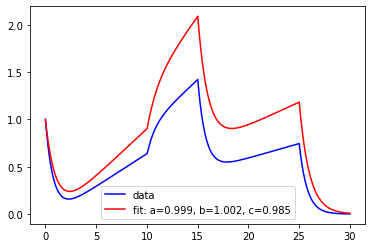

In [ ]:
fit_r = my_solver(t_array, T, Kopt[0], Kopt[1], Kopt[2], r0, p, b)
plt.plot(t_array, r, 'b-', label='data')
plt.plot(t_array, fit_r, 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(Kopt))
plt.legend()
plt.show()